In [ ]:
! pip install --quiet gensim

In [1]:
import pandas as pd
import re
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

yelps = pd.read_csv('sentiment/yelps.csv')
#shuffle the df so the positive and negatve aren't separated
yelps = yelps.sample(frac=1).reset_index(drop=True)

In [2]:
from bs4 import BeautifulSoup

def clean_yelp(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """

    token_pattern=r"(?u)\b\w\w+\b"
    token_pattern = re.compile(token_pattern)
    return token_pattern.findall(s)
    # Implement this function!
    # Hint: If you look at the sklearn source code on github, 
    # you will find a good regular expression they use as a default
    # tokenizer in CountVectorizer -- this is the tokenizer
    # we have been using until now!
    # But you need to implement your own now. 

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

# Create a count vectorizer, using the preprocessor and tokenizer from above
# use TruncatedSVD from Sklearn to generate a term embedding matrix for your data
# that is 100 dimensional in size.
# Embed your documents via that term embedding matrix (this is just the PCA of the 
# TF matrix, as returned by "transform" on TruncatedSVD
countv = CountVectorizer(preprocessor=clean_yelp, tokenizer=tokenize)
TF_matrix = countv.fit_transform(yelps.text)

trun = TruncatedSVD(n_components=100)
SVD_matrix = trun.fit_transform(TF_matrix)

# Here you should have TWO vector representations of your Yelp data: 
# 1. The original TF matrix
# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD

/home/eric/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/eric/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [4]:
from sklearn.metrics import accuracy_score

def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression(solver='lbfgs', max_iter=250)
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

In [5]:
# Test your vector representations using the above function, test_holdout_vectors. 
# for several levels of "cutoff". 
cuts = [100, 250, 500, 1000, 5000, 10000, 25000, 50000, 75000]
full = [test_holdout_vectors(TF_matrix, yelps.positive, c) for c in cuts]
truncated = [test_holdout_vectors(SVD_matrix, yelps.positive, c) for c in cuts]
# This function simulates training on a small part of your data and testing on the rest.
# Thus, it's as though you have some labelled data but a bunch of unlabelled data. 
# This is essentially a semi-supervised situation. 
# Do the word embeddings generated via SVD allow you to pull information from the 
# unlabeled data and improve your score given a small training set? 

/home/eric/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/eric/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/eric/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


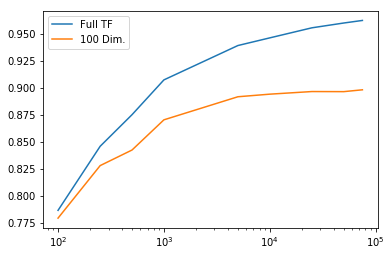

In [6]:
plt.plot(cuts, full)
plt.plot(cuts, truncated)
plt.legend(['Full TF', '100 Dim.'])
plt.xscale("log")

For small training datasets, the SVD commes close (or in some shuffles can outperform) the full TF embedding - though the accuracy gap increases as we add more data..

In [7]:
from gensim.models import Word2Vec

# Next, create another term embedding via Word2Vec, also 100 dimensional
# Look at the documentation from the library gensim and see what hyperparameters
# you can choose to tune. 
# Note: training takes time, so you probably won't want to try too many!
sentences = yelps.text.apply(clean_yelp).apply(tokenize)
model = Word2Vec(sentences, window=5, min_count=5, workers=4)
# pass the cleaned and tokenized yelp reviews as "sentences" to your model
# to build the vocabulary and train the word vectors. 

/home/eric/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/eric/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [8]:
import numpy as np

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0) #fixed to add summation
    a /= np.linalg.norm(a)
    return a

# use as follows: np.array([embed_w2v(t, w2v) for t in X])

In [9]:
# use the embed_w2v function to embed your Yelp reviews using the new
# word2vec word embeddings. Each review will be a normalized sum of the
# words that it is made of. 
# See how this improves the scores in the classification task using
# test_holdout_vectors -- is word2vec better? At what training-set sizes does it help
# more? 
w2v_matrix = np.array([embed_w2v(t, model) for t in sentences2])
w2v_test = [test_holdout_vectors(w2v_matrix, yelps.positive, c) for c in cuts]

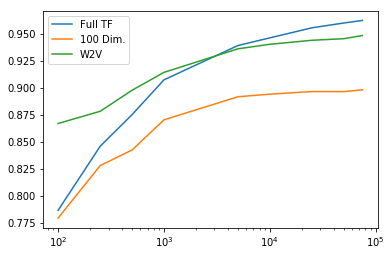

In [10]:
#plot accuracy
plt.plot(cuts, full)
plt.plot(cuts, truncated)
plt.plot(cuts, w2v_test)
plt.legend(['Full TF', '100 Dim.', 'W2V'])
plt.xscale("log")

word2vec clearly outperforms the SVD - and for smaller training sets, outperforms the full TF as well.

In [34]:
from re import sub, split
import spacy
nlp_en = spacy.load('en')

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!
    s = sub("RT ", "", s) #retweets
    s = sub("@[A-Za-z0-9_=:.]*", "", s) #mentions
    s = sub(r"http\S+", "", s) #hyperlinks
    s = sub("\n", " ", s) #carriage returns
    s = sub("w/", "with", s) #with
    s = sub("#", "", s) #hashtag start
    s = sub("%", " percent", s) #percent
    s = sub("&amp;", "and", s) #ampersand
    s = sub("&gt;", "", s) #greater than...
    s = sub(' +', ' ',s) #extra spaces
    s = s.lower()

    # BONUS: Try using the library "spacy" to 
    # do further processing, such as lemmatizing
    # or replacing Named Entities with constants (i.e. "[NAMED]")
    # or adding the part of speech or dependency code to the word 
    doc = nlp_en(s)
    NE = str(list(doc.ents)) #Named Entities
    for token in doc:
        #Add POS tags
        #s = ([token.lemma_ + "_" + token.pos_ for token in doc if not (token.is_stop | token.is_punct)])
        #get lemmas, turn emojis to text, remove punctuation and stopwords
        s = ([emoji.demojize(token.lemma_) for token in doc if not (token.is_stop | token.is_punct)])
        #replace named entities with constant 
        s = [t if t not in NE else '[NAMED]' for t in s]
        s = ' '.join([w for w in s])
    return s

In [17]:
# Load tweet!
# NOTE: this file needs to be downloaded from Box! 
with open('tweets/tweets.txt') as f:
    tweets = pd.Series(f.readlines())

In [35]:
# Now embed this twitter data, again using Word2Vec and LSA (SVD)
# you don't have any labels, but you might be able to 
# find some interesting phenomena. 
countv2 = CountVectorizer(preprocessor=clean_twitter)
TF_tweets = countv2.fit_transform(tweets)

trun2 = TruncatedSVD(n_components=100)
SVD_tweets = trun2.fit_transform(TF_tweets)

In [38]:
#prepare word2vec 'sentences'
sentences2 = [clean_twitter(t).split(' ') for t in tweets]
model_tweet = Word2Vec(sentences2, workers=4)
#save model
model_tweet.save("tweet_model.w2v")

In [39]:
#embeddings
w2v_tweets = np.array([embed_w2v(t, model_tweet) for t in sentences2])

In [40]:
# Explore using either or both of the following tools: 
# 1. Word2Vec has a built in feature for getting most similar
# words, including via positive/negative examples (subtraction)
# What happens when you subtract "hillary" from "trump"? 
display(model_tweet.wv.most_similar('trump'))
display(model_tweet.wv.most_similar('hillary'))
display(model_tweet.wv.most_similar(positive=['trump'], negative=['hillary']))

[("'s", 0.5481735467910767),
 ('gop', 0.5312215089797974),
 ('rnc', 0.5231875777244568),
 ('opponent', 0.5220933556556702),
 ('limbaugh', 0.5172319412231445),
 ('candidate', 0.509375274181366),
 ('huge', 0.5082424879074097),
 ('t', 0.5079197287559509),
 ('’s', 0.5017178058624268),
 ('wh', 0.49795353412628174)]

[('hrc', 0.7221077680587769),
 ('hilary', 0.694828450679779),
 ('killary', 0.619983434677124),
 ('sander', 0.5963904857635498),
 ('hiliary', 0.5868120193481445),
 ('hilliary', 0.5839390754699707),
 ('crookedhillary', 0.5547609925270081),
 ('fdn', 0.5422053337097168),
 ('hillaryclinton', 0.5290896892547607),
 ('chelsea', 0.5010946393013)]

[('j.', 0.4117026925086975),
 ('eiffel', 0.3998677134513855),
 ('j', 0.3779871463775635),
 ('nativism', 0.3762831687927246),
 ('tusk', 0.37169933319091797),
 ('francis', 0.3655794560909271),
 ('coulter', 0.3381178379058838),
 ('g7', 0.3326679766178131),
 ('sabato', 0.3275608420372009),
 ('diego', 0.32604295015335083)]

In [49]:
# Bonus: build a similar feature for your LSA features and
# see if you can do similar vector math
from sklearn.metrics.pairwise import cosine_similarity
word1 = 'trump'
word2 = 'hillary'
#get full vocabulary
voc = countv2.vocabulary_
#find indicies in dictionary of chosen words
ind1 = list(voc.keys()).index(word1)
ind2 = list(voc.keys()).index(word2)
#vectors with only chosen words...
vect1 = np.zeros(len(voc))
vect1[ind1] = 1
vect2 = np.zeros(len(voc))
vect2[ind2] = 1

#transform using previously fit SVD
word1_lsa = trun2.transform(vect1.reshape(1, -1))
word2_lsa = trun2.transform(vect2.reshape(1, -1))
#vector difference
diff_lsa = word1_lsa - word2_lsa

#store similarities
similar_list1 = []
similar_list2 = []
similar_list3 = []
i=0
#only look at first 10,000 word in vocabulary - already very slow
for w in list(voc.keys())[:10000]:
    #transform each new vocab word
    vect = np.zeros(len(voc))
    vect[i] = 1
    vect_lsa = trun2.transform(vect.reshape(1, -1))
    #compute and save similarities
    similar_list1.append([w, cosine_similarity(word1_lsa, vect_lsa)[0][0]])
    similar_list2.append([w, cosine_similarity(word2_lsa, vect_lsa)[0][0]])
    similar_list3.append([w, cosine_similarity(diff_lsa, vect_lsa)[0][0]])
    i+=1
#sort to get most similar
similar = pd.DataFrame(similar_list1, columns=['word', 'cos_sim']).sort_values('cos_sim', ascending=False)
print(similar[similar.cos_sim<0.99999].head(10))
similar = pd.DataFrame(similar_list2, columns=['word', 'cos_sim']).sort_values('cos_sim', ascending=False)
print(similar[similar.cos_sim<0.99999].head(10))
similar = pd.DataFrame(similar_list3, columns=['word', 'cos_sim']).sort_values('cos_sim', ascending=False)
print(similar[similar.cos_sim<0.99999].head(10))

            word   cos_sim
2505     tequila  0.923110
936       speech  0.911964
334        idiot  0.910632
1200        veto  0.907999
1847       santa  0.876007
6906  truthcrumb  0.871847
3920     phillie  0.839539
2106     fboloud  0.836398
8059     wünsche  0.835356
7776  diplomatic  0.834072
                         word   cos_sim
6716                   custom  0.916815
6718      westerncivilization  0.914479
2372                    offer  0.900371
4506               delusional  0.899536
8574                anarchist  0.896114
9999              handwritten  0.895956
586   donaldtrumpforpresident  0.895401
2885                   handle  0.895370
4403         mountain_railway  0.894936
7011                   barker  0.894166
                       word   cos_sim
40                    trump  0.882683
2505                tequila  0.817098
936                  speech  0.805633
1200                   veto  0.801264
334                   idiot  0.792133
1847                  santa  0.7824

In [50]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]))

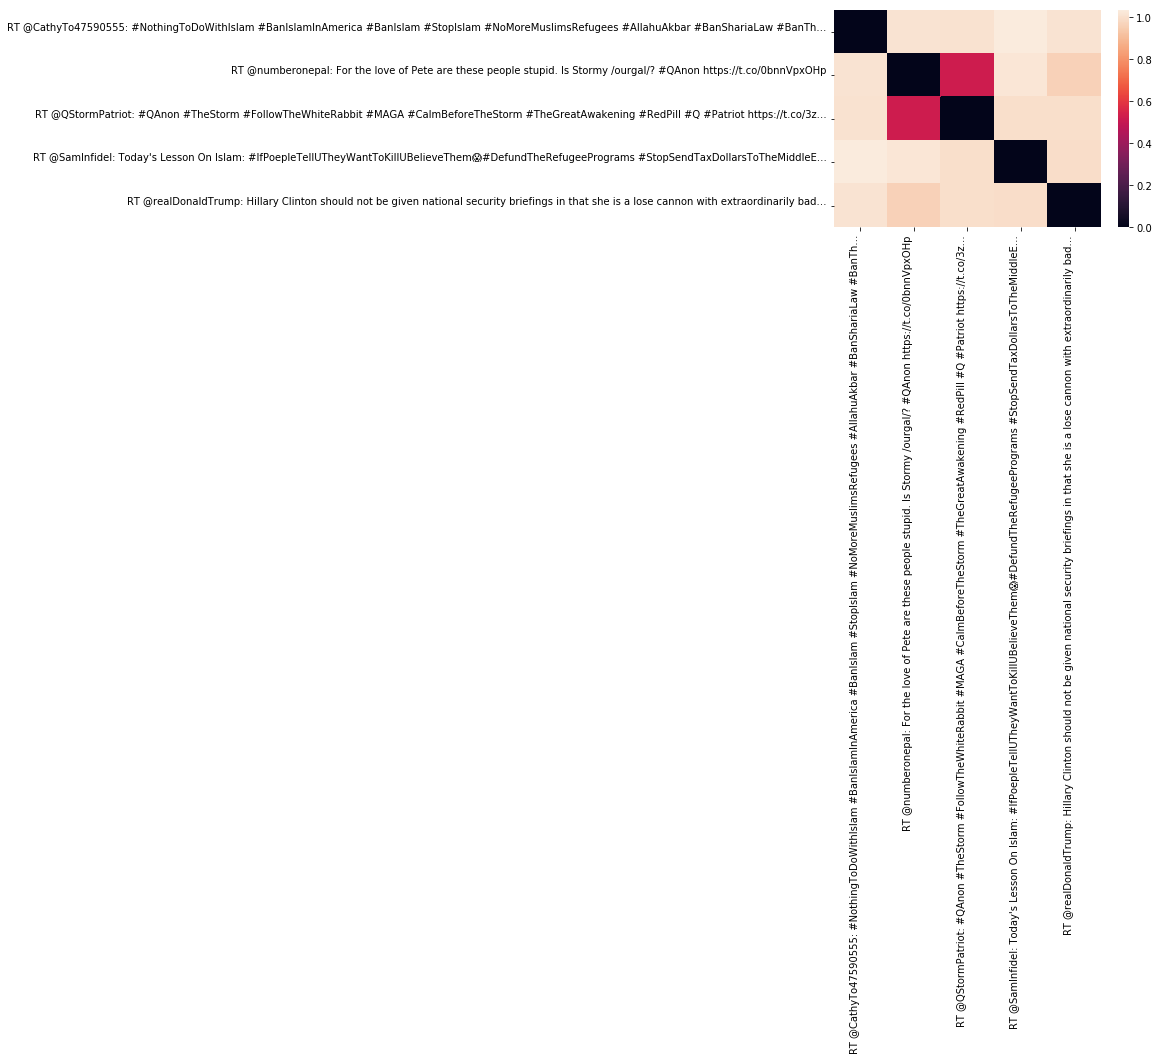

In [53]:
# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another? 
idx = np.random.randint(0, high=len(tweets), size=5)
visualize_dist(SVD_tweets, tweets, idx)

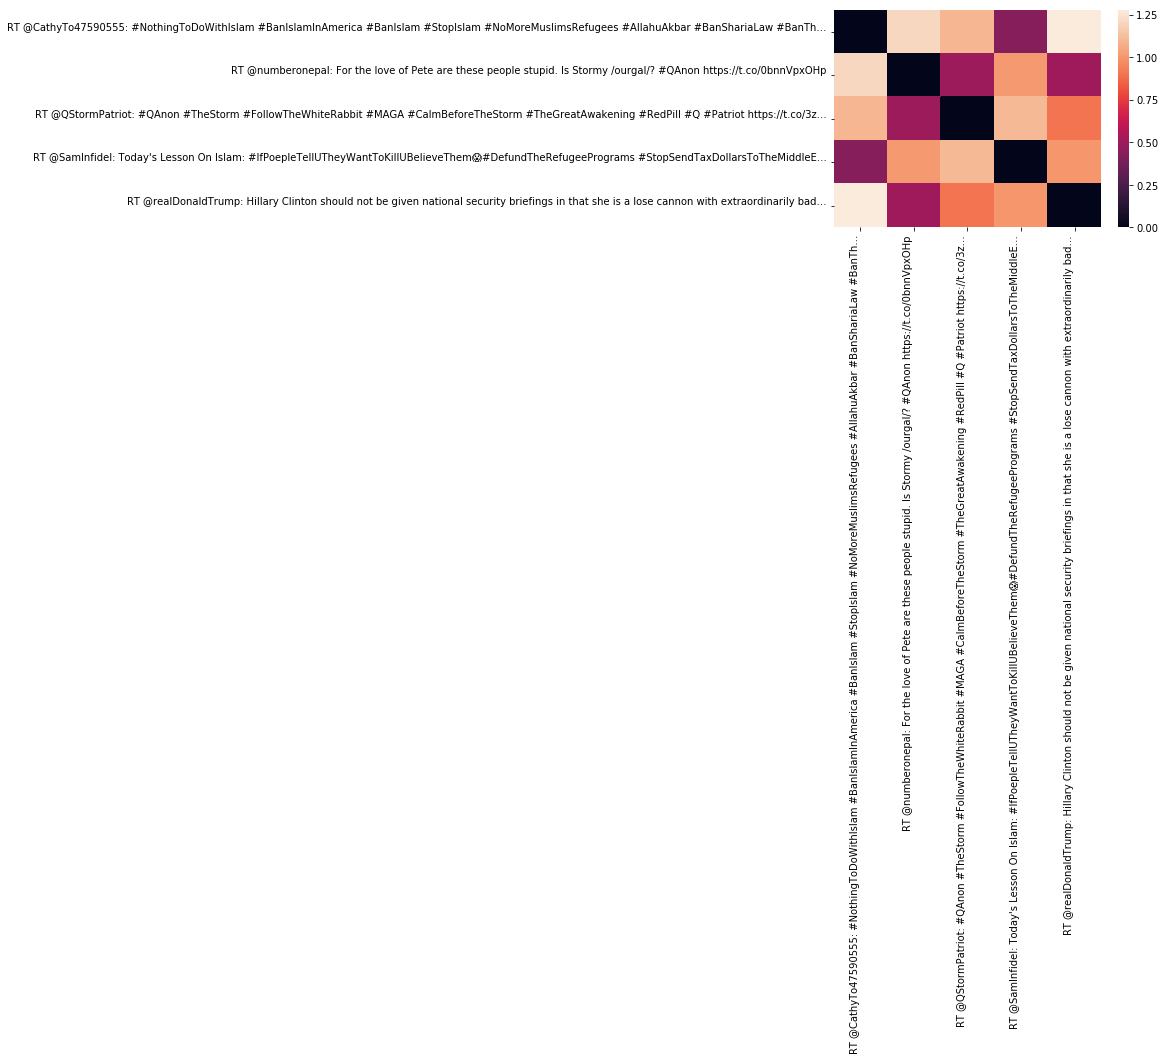

In [54]:
visualize_dist(w2v_tweets, tweets, idx)

The word2vec embedding seems to be a bit better for most samples - here we also see a wider dispersion of seperation between similar and dissimilar..

In [57]:
# More bonus!
# Use one of the following pre-embedded models and see if your yelp scores improve? 
# What about your Twitter explorations?

# https://github.com/RaRe-Technologies/gensim-data
import gensim.downloader as api
model_goog = api.load("word2vec-google-news-300") 

In [59]:
#embed with google model
goog_yelp = np.array([embed_w2v(t, model_goog) for t in yelps.text.apply(clean_yelp).apply(tokenize)])
goog_tweet = np.array([embed_w2v(t, model_goog) for t in sentences2])

/home/eric/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/eric/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/eric/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/home/eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: D

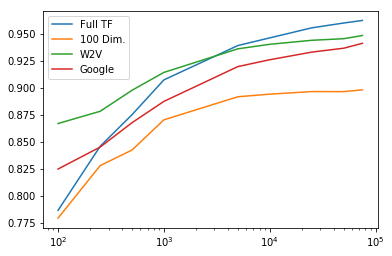

In [60]:
#plot all models
goog_test = [test_holdout_vectors(goog_yelp, yelps.positive, c) for c in cuts]
plt.plot(cuts, full)
plt.plot(cuts, truncated)
plt.plot(cuts, w2v_test)
plt.plot(cuts, goog_test)
plt.legend(['Full TF', '100 Dim.', 'W2V', 'Google'])
plt.xscale("log")

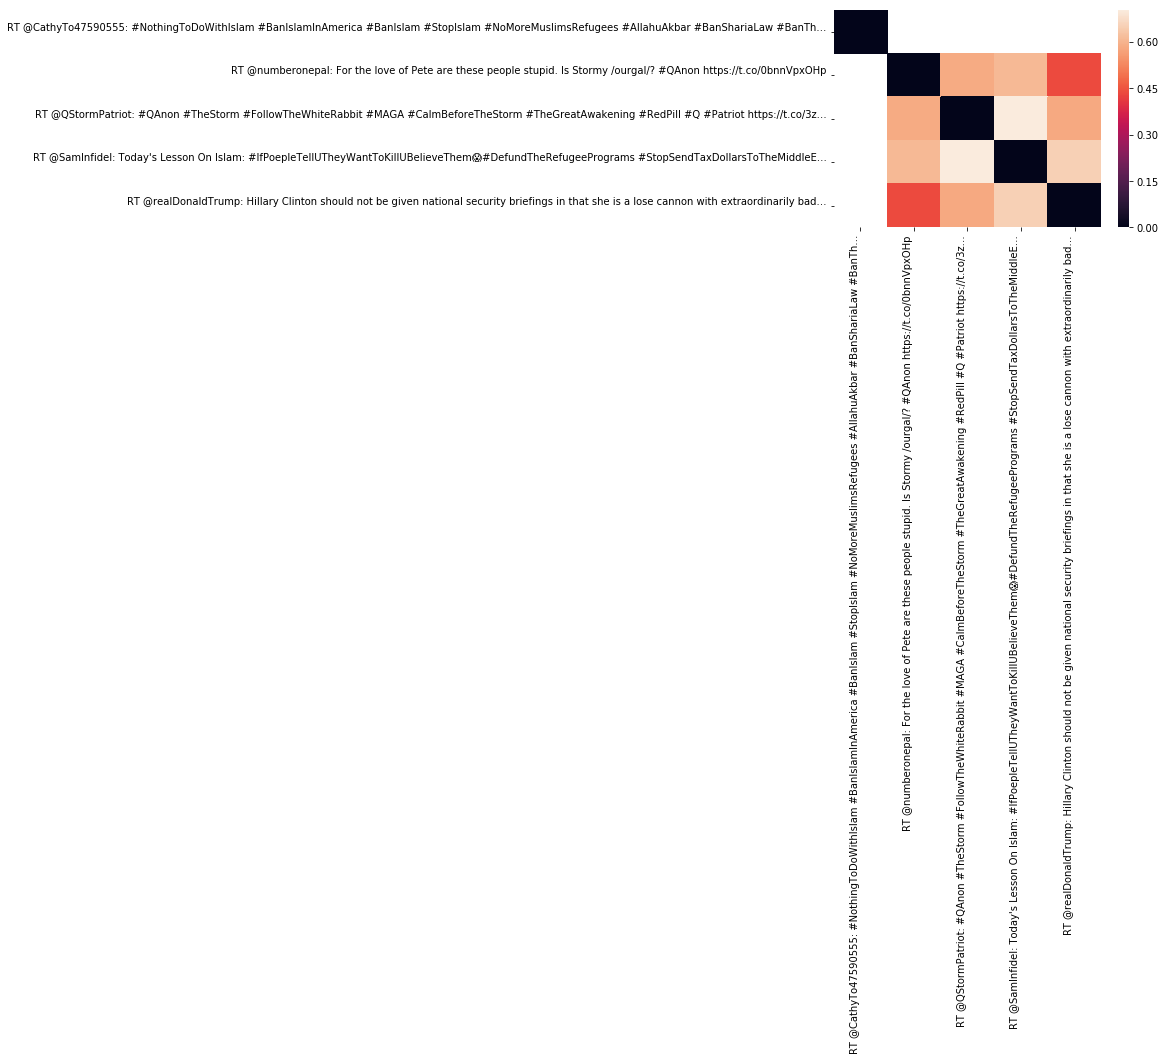

In [61]:
visualize_dist(goog_tweet, tweets, idx)

So reasonably comparable performance from the google pre-trained model - which is fairly impressive as the rest are built from vocabulary only specific to our training/test sets..